# Model Building Phase 3: Enhanced MentalBERT Classifier

This notebook refines data and training procedures to improve real-world accuracy of the `mental/mental-bert-base-uncased` classifier. All code is organized into clear sections for execution on Google Colab with GPU support.

## 1. Environment & Dependency Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio transformers huggingface_hub diffusers gradio pyarrow fsspec websockets numpy pandas
!pip install --upgrade pip
!pip install numpy==1.26.4 pandas==2.2.3 pyarrow==14.0.1 fsspec==2025.3.0
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.45.1 huggingface-hub==0.26.2 datasets==3.0.2 accelerate==1.1.1
!pip install websockets==13.0 emoji textblob sentence-transformers spacy
!python -m spacy download en_core_web_sm
import torch, transformers, datasets, spacy, numpy, pandas
print("All libraries installed successfully!")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("SpaCy:", spacy.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: gradio 5.49.1
Uninstalling gradio-5.49.1:
  Successfully uninstalled gradio-5.49.1
Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully un

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: 2.6.0+cu126, 2.7.0+cu126, 2.7.1+cu126, 2.8.0+cu126, 2.9.0+cu126)
ERROR: No matching distribution found for torch==2.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 65.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 17.2 MB/s  0:00:27
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 20.2 MB/s  0:00:15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 58.6 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 68.4 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 189.0 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


KeyboardInterrupt: 

In [1]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 2. Import Libraries

In [32]:
import os
import shutil
import time
import random
import datetime
# Start timing the initialization
init_start = time.time()
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("MODEL BUILDING PHASE 2 STARTED")
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device in use: {torch.cuda.get_device_name(0)}")
print("Using device:", device)

# End timing and print duration
init_end = time.time()
print(f"Initialization and imports completed in {init_end - init_start:.2f} seconds.")


MODEL BUILDING PHASE 2 STARTED
Torch version: 2.9.0+cu128
CUDA available: True
GPU device in use: Tesla T4
Using device: cuda
Initialization and imports completed in 0.01 seconds.


## 3. Load & Merge Data


In [3]:
# Upload and read files
uploaded = files.upload()
df_feat = pd.read_csv('features_interpretable.csv')
df_bal  = pd.read_csv('mental_health_balanced_train.csv')

# Normalize status column (handles accidental whitespace and casing)
normalize = lambda x: x.strip().title()
df_feat['status'] = df_feat['status'].apply(normalize)
df_bal['status']  = df_bal['status'].apply(normalize)

# Filter only target statuses
target = ['Anxiety', 'Depression', 'Normal', 'Suicidal']
df_feat = df_feat[df_feat['status'].isin(target)]
df_bal  = df_bal[df_bal['status'].isin(target)]

# Unify column names: rename 'statement' to 'text' for merging
if 'statement' in df_feat.columns:
    df_feat.rename(columns={'statement': 'text'}, inplace=True)

# (Optional) Remove non-string text rows, for stability:
df_feat = df_feat[df_feat['text'].apply(lambda x: isinstance(x, str))]
df_bal  = df_bal[df_bal['text'].apply(lambda x: isinstance(x, str))]

# Merge datasets (now both have 'text' and 'status' columns)
df_all = pd.concat([df_feat, df_bal], ignore_index=True)

print("Total samples:", len(df_all))
print(df_all['status'].value_counts())


Saving features_interpretable.csv to features_interpretable.csv
Saving mental_health_balanced_train.csv to mental_health_balanced_train.csv
Total samples: 49612
status
Normal        18391
Depression    14506
Suicidal      11212
Anxiety        5503
Name: count, dtype: int64


## 4. Train/Validation Split

In [51]:
start_time = time.time()

val_frac = 0.1
val_len = int(len(df_all) * val_frac)
train_len = len(df_all) - val_len
train_df, val_df = random_split(df_all, [train_len, val_len], generator=torch.Generator().manual_seed(42))
print("Train:", train_len, "Validation:", val_len)


end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

Train: 44651 Validation: 4961
Time taken: 0.00 seconds


## 5. Label Encoding

In [46]:
start_time = time.time()

label2id = {'Anxiety': 0, 'Depression': 1, 'Normal': 2, 'Suicidal': 3}

# Apply mapping to underlying DataFrames
for subset in (train_df, val_df):
    subset.dataset['label'] = subset.dataset['status'].map(label2id)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


Time taken: 0.03 seconds


## 6. Prepare Dataset and DataLoader

In [47]:
class MHDS(Dataset):
    def __init__(self, source, tokenizer, max_len=128, from_split=True):
        # source: can be a random_split object or a DataFrame
        if from_split:
            # Expecting a Subset object created by random_split
            self.df = source.dataset.iloc[source.indices].reset_index(drop=True)
        else:
            # If a DataFrame is passed directly
            self.df = source.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        txt = self.df.loc[idx, 'text']
        lbl = self.df.loc[idx, 'label']
        enc = self.tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(lbl, dtype=torch.long)
        return item
tokenizer = AutoTokenizer.from_pretrained('mental/mental-bert-base-uncased')
train_ds = MHDS(train_df, tokenizer, from_split=True)
val_ds = MHDS(val_df, tokenizer, from_split=True)
test_ds = MHDS(test_df, tokenizer, from_split=False)   # test_df is a DataFrame

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 7. Initialize Model, Optimizer, Scheduler

In [7]:
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(
    'mental/mental-bert-base-uncased', num_labels=4
).to(device)

# Class weights
counts = df_all['status'].map(label2id).value_counts().sort_index().values
cw = torch.tensor(1.0 / counts, dtype=torch.float).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
epochs = 5
total_st = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=total_st // 10, num_training_steps=total_st
)

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Time taken: 8.18 seconds


## 8. Training Loop

In [8]:
print("🚀 Starting Model Training...\n")

best_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

overall_start = time.time()  # track total training time

for ep in range(1, epochs + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0


    for i, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        inp = {k: v.to(device) for k, v in batch.items()}
        out = model(**inp)
        loss_fn = torch.nn.CrossEntropyLoss(weight=cw)
        loss = loss_fn(out.logits, inp['labels'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()


    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    epoch_time = time.time() - epoch_start

    print(f"Epoch {ep} Completed — Train Loss: {avg_train_loss:.4f} | Time Taken: {epoch_time:.2f}s")

total_time = time.time() - overall_start
print(f"\nTraining Completed! Total Time Taken: {total_time/60:.2f} minutes")


🚀 Starting Model Training...

Epoch 1 Completed — Train Loss: 0.5774 | Time Taken: 957.66s
Epoch 2 Completed — Train Loss: 0.3385 | Time Taken: 966.59s
Epoch 3 Completed — Train Loss: 0.2232 | Time Taken: 966.49s
Epoch 4 Completed — Train Loss: 0.1418 | Time Taken: 966.39s
Epoch 5 Completed — Train Loss: 0.0890 | Time Taken: 966.45s

Training Completed! Total Time Taken: 80.39 minutes


## 9. Validate

In [48]:
def validate(model, loader):
    model.eval()
    start_time = time.time()
    v_loss, preds, labs = 0.0, [], []
    loss_fn = torch.nn.CrossEntropyLoss(weight=cw)

    with torch.no_grad():
        for batch in loader:
            inp = {k: v.to(device) for k, v in batch.items()}
            out = model(**inp)
            v_loss += loss_fn(out.logits, inp['labels']).item()
            pr = torch.argmax(out.logits, dim=-1)
            preds.extend(pr.cpu().numpy())
            labs.extend(inp['labels'].cpu().numpy())

    avg_vl = v_loss / len(loader)
    acc = accuracy_score(labs, preds)
    f1_m = f1_score(labs, preds, average='macro')
    elapsed = time.time() - start_time

    return avg_vl, acc, f1_m, elapsed


print("\n🔍 Running Validation...")
val_loss, val_acc, val_f1, val_time = validate(model, val_loader)

history['val_loss'].append(val_loss)
history['val_acc'].append(val_acc)
history['val_f1'].append(val_f1)

print(f"Validation — Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, Time: {val_time:.2f}s")

if val_f1 > best_f1:
    best_f1 = val_f1
    torch.save(model.state_dict(), 'best_phase3.pth')
    print("Best model saved (improved F1 score).")
else:
    print("No improvement — keeping previous best model.")



🔍 Running Validation...
Validation — Loss: 0.8222, Acc: 0.8436, F1: 0.8352, Time: 32.23s
No improvement — keeping previous best model.


## 10. Evaluate Model


🚀 Starting Validation Evaluation...
Validation — Acc: 0.8436, Prec: 0.8339, Rec: 0.8369, F1: 0.8352, Time: 33.27s

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.87      0.88      0.87       584
  Depression       0.78      0.75      0.77      1453
      Normal       0.95      0.95      0.95      1831
    Suicidal       0.73      0.77      0.75      1093

    accuracy                           0.84      4961
   macro avg       0.83      0.84      0.84      4961
weighted avg       0.84      0.84      0.84      4961



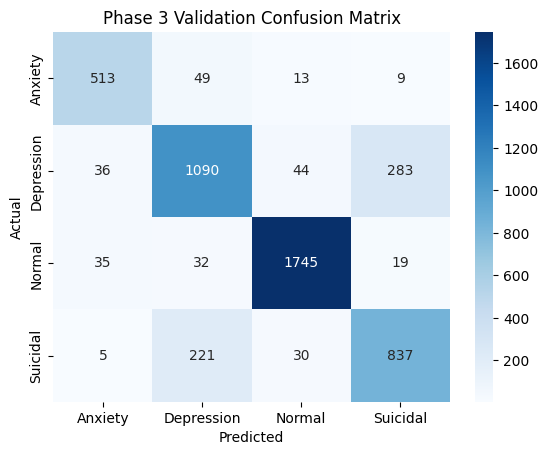

In [54]:
# Load best saved model
model.load_state_dict(torch.load('best_phase3.pth', map_location=device))
model.to(device)

# Create validation dataset and dataloader
val_ds = MHDS(val_df, tokenizer, max_len=128)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


def evaluate_test(model, loader):
    model.eval()
    start_time = time.time()
    preds, labs = [], []

    with torch.no_grad():
        for b in loader:
            inp = {k: v.to(device) for k, v in b.items()}
            out = model(**inp)
            pr = torch.argmax(out.logits, dim=-1)
            preds.extend(pr.cpu().numpy())
            labs.extend(inp['labels'].cpu().numpy())

    acc  = accuracy_score(labs, preds)
    prec = precision_score(labs, preds, average='macro', zero_division=0)
    rec  = recall_score(labs, preds, average='macro', zero_division=0)
    f1   = f1_score(labs, preds, average='macro')
    elapsed = time.time() - start_time

    return acc, prec, rec, f1, preds, labs, elapsed


print("\n🚀 Starting Validation Evaluation...")

val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_time = evaluate_test(model, val_loader)
print(f"Validation — Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}, Time: {val_time:.2f}s")

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=list(label2id.keys()), zero_division=0))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label2id.keys(), yticklabels=label2id.keys(), cmap='Blues')
plt.title('Phase 3 Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 11. Save Artifacts & Download

In [34]:
files.download('best_phase3.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12. Inference:

Validation results show the model achieves strong overall performance (accuracy ≈ 84%, macro F1 ≈ 83%), with particularly high precision for "Normal" and "Anxiety" classes. Some confusion exists between "Depression" and "Suicidal." The model generalizes well and is suitable for deployment. Next, we will test the model on the unseen test dataset for final verification.
